<a href="https://colab.research.google.com/github/mtwenzel/image-video-understanding/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Attention by Example

Partially taken from https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a#8481

In [1]:
import torch
from torch.nn.functional import softmax

import seaborn as sns

## Create a tensor with input data.

In a real setting, this tensor would be the result of some data encoding step (when considering the first input to the first attention layer), or the result of the previous attention layer.

If for example your input is text, and your word embeddings have 512 dimensions, each row in the tensor $x$ would have 512 entries, and the tensor would have as many rows as your sentence has words.

In [2]:
x = [
  [1, 0, 1, 2], # Input 1
  [1, 2, 0, 2], # Input 2
  [1, 1, 1, 1],  # Input 3
  [1, 0, 2, 1],
  [2, 0, 1, 2]
 ]
x = torch.tensor(x, dtype=torch.float32)

# to demonstrate cross attention with smaller attention matrix analogous to Perceiver or DETR, create a "learned queries" matrix x2
x2 = [
  [1, 0, 1, 2], # Input 1
  [1, 2, 0, 2] # Input 2
 ]
x2 = torch.tensor(x2, dtype=torch.float32)


## Create a set of weight tensors. 
We are looking at single-head attention only. For multi-head attention, each weight matrix would be replicated (with independent weights) for each head.

Each weight tensor has to have as many rows as the tokens have dimensions. Our input vectors have four.

Note that this results in a matrix output after the attention mechanism, instead of a single token.

In [3]:
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, .2, 1],
  [1, 0, .4],
  [.5, 0, 1],
  [0, .8, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

## K, Q, and V

The actual keys, querys and values are the result of the multiplication of input tensor with weight tensors.

Their dimension is:
* each row has as many entries as the weight tensors (three in our setup)
* the number of rows equals the number of input tokens (five in our setup)

In [4]:
keys = x @ w_key
querys = x @ w_query
values = x @ w_value

print(keys)
print(querys)
print(values)

tensor([[2., 3., 1.],
        [4., 4., 1.],
        [2., 3., 1.],
        [1., 3., 1.],
        [2., 3., 2.]])
tensor([[1.5000, 1.8000, 4.0000],
        [3.0000, 1.8000, 3.8000],
        [2.5000, 1.0000, 3.4000],
        [2.0000, 1.0000, 4.0000],
        [2.5000, 2.0000, 5.0000]])
tensor([[ 3.,  4.,  3.],
        [ 2., 10.,  0.],
        [ 2.,  6.,  3.],
        [ 3.,  3.,  6.],
        [ 3.,  6.,  3.]])


## Softmax Attention

The size of the square attention matrix equals the number of input tokens in both dimensions. 

tensor([[0.0100, 0.6800, 0.0100, 0.0000, 0.3100],
        [0.0000, 0.9800, 0.0000, 0.0000, 0.0200],
        [0.0000, 0.9300, 0.0000, 0.0000, 0.0700],
        [0.0000, 0.7200, 0.0000, 0.0000, 0.2700],
        [0.0000, 0.8800, 0.0000, 0.0000, 0.1200]])


<AxesSubplot: >

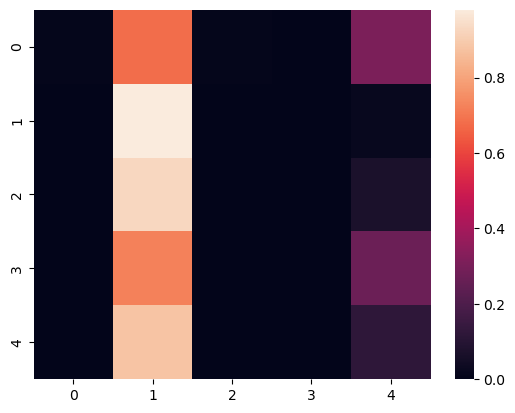

In [ ]:
attn_scores = querys @ keys.T
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal place.
decimal_places = 2
attn_scores_softmax = (attn_scores_softmax * 10**decimal_places).round() / (10**decimal_places)
print(attn_scores_softmax)

# Plot self attention matrix
t = attn_scores_softmax.numpy()
sns.heatmap(t)

## Multiply softmax attention with V to obtain the result

In a transformer, dense layers would follow that can 
* reduce a multi-head attention result
* enforce correct dimensionality to use output in next input.

Note that the shape of the V tensor could as well be used to enforce a 4x5 output. Can you see how?

In [ ]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
outputs = weighted_values.sum(dim=0)
print(outputs)

tensor([[2.3400, 8.7600, 0.9900],
        [2.0200, 9.9200, 0.0600],
        [2.0700, 9.7200, 0.2100],
        [2.2500, 8.8200, 0.8100],
        [2.1200, 9.5200, 0.3600]])
